# Import packages

In [12]:
! pip install -q pydeseq2
! pip install -q sanbomics
! pip install -q gseapy
! pip install -q scanpy
! pip install -q bioinfokit

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl


In [14]:
import gseapy as gp

In [15]:
import sanbomics.tools as tools

In [16]:
from pydeseq2.dds import DeseqDataSet

In [17]:
from pydeseq2.ds import DeseqStats

In [18]:
from gseapy.plot import gseaplot

In [19]:
from gseapy import enrichment_map

In [20]:
import scanpy as sc

In [21]:
import bioinfokit

# Question 2: Differential Gene Expression Analysis

## 2.1 Data loading

In [22]:
'''
TODO: Load the gene count 'HW3_Data.csv' file.
'''
# number of genes x number of samples
data = pd.read_csv('HW3_Data.csv')
data


,Gene_ID,P_s1,P_s4,P_s8,P_s10,S_s3,S_s5,S_s11,S_s14
0,ENSG00000175262,0,0,0,0,0,0,0,0
1,ENSG00000279457,6,7,8,7,6,0,10,9
2,ENSG00000162571,0,0,0,0,0,0,0,0
3,ENSG00000231181,1,1,1,1,0,1,0,0
4,ENSG00000238173,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
59972,ENSG00000205581,1501,1628,2061,2044,913,854,1335,985
59973,ENSG00000252915,1,2,0,0,0,0,1,1
59974,ENSG00000227406,0,0,0,0,0,0,0,0
59975,ENSG00000182093,208,331,244,382,235,133,244,313


## 2.2 Data filtering

In [23]:
'''
TODO: Filter out genes that have less than 5 read counts in total

Hint: column sum (or row sum) >= 5
'''
counts_df = data.T

counts_df.columns = counts_df.iloc[0]
counts_df = counts_df[1:]

genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 5]
counts_df = counts_df[genes_to_keep]
counts_df



Gene_ID,ENSG00000279457,ENSG00000231181,ENSG00000158109,ENSG00000037637,ENSG00000184163,ENSG00000159423,ENSG00000142599,ENSG00000011021,ENSG00000272482,ENSG00000284747,...,ENSG00000159082,ENSG00000224905,ENSG00000155304,ENSG00000235701,ENSG00000183527,ENSG00000185658,ENSG00000255568,ENSG00000205581,ENSG00000252915,ENSG00000182093
P_s1,6,1,847,297,6,241,1394,209,16,5,...,280,5,1297,0,377,610,1,1501,1,208
P_s4,7,1,1791,339,18,229,2196,263,19,3,...,1401,5,2620,3,452,926,1,1628,2,331
P_s8,8,1,810,289,8,229,2399,204,20,6,...,332,2,1472,0,597,704,5,2061,0,244
P_s10,7,1,1215,345,7,286,1965,230,5,3,...,462,4,1480,0,573,785,6,2044,0,382
S_s3,6,0,1799,270,4,176,1815,216,34,7,...,560,3,1618,0,350,642,0,913,0,235
S_s5,0,1,804,277,3,124,1065,117,15,1,...,146,0,1158,0,152,556,0,854,0,133
S_s11,10,0,1347,347,4,196,2328,163,25,5,...,289,1,1122,1,329,781,2,1335,1,244
S_s14,9,0,1299,285,4,188,1433,146,18,1,...,324,2,1080,1,256,675,2,985,1,313


## 2.3 Metadata

In [40]:
'''
TODO: Infer metadata from sample names

Hint: the metadata matrix is of shape [8 samples, 2 groups]
The metadata matrix has a shape 8 x 2, the 1st col contains sample names, and the 2nd col indicates P or S

Each sample is named as: group + sample_id.
For example, 'P_s4' implies that sample with ID 4 is from group P.
'''

metadata = pd.DataFrame({'Sample Name':['P_s1', 'P_s4', 'P_s8', 'P_s10', 'S_s3', 'S_s5', 'S_s11', 'S_s14'],
                         'condition': ['P', 'P', 'P', 'P', 'S', 'S', 'S', 'S']})



metadata1 = metadata.set_index('Sample Name')
metadata1


,condition
Sample Name,
P_s1,P
P_s4,P
P_s8,P
P_s10,P
S_s3,S
S_s5,S
S_s11,S
S_s14,S


## 2.4 PCA

In [25]:
'''
TODO: Create a DeseqDataSet object from the count and metadata data.

Hint: PyDEseq2 https://pydeseq2.readthedocs.io/en/latest/auto_examples/index.html
'''

dds = DeseqDataSet(counts=counts_df, metadata=metadata1, design_factors='condition')


In [26]:
print(dds)

AnnData object with n_obs × n_vars = 8 × 22214
    obs: 'condition'
    obsm: 'design_matrix'


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


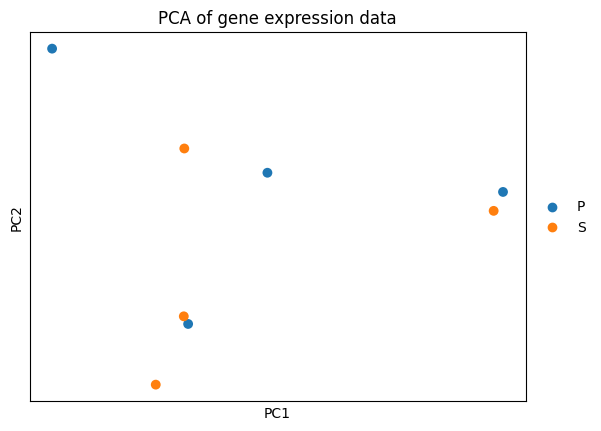

In [41]:
'''
TODO: Generate a principal component plot of the samples.

Hint: You could use scanpy.
  https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.pca.html
  https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.pca.html
'''


adata = sc.AnnData(X=counts_df, obs=metadata1)
sc.tl.pca(adata)
sc.pl.pca(adata, color='condition', size= 200, title='PCA of gene expression data')
# show axes

## 2.5 Identification of differentially expressed genes

In [28]:
'''
TODO: Fit dispersions and LFCs

Hint: Run the deseq2() method
'''
# Fit the DESeq2 model
dds.deseq2()


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 27.99 seconds.

Fitting dispersion trend curve...
... done in 9.80 seconds.

Fitting MAP dispersions...
... done in 37.29 seconds.

Fitting LFCs...
... done in 17.27 seconds.

Refitting 0 outliers.



In [29]:
'''
TODO: Perform statistical tests to compute p-values and adjusted p-values.
      Set the significance threshold to be 0.01.
      Save the results to a dataframe.

Hint: DeseqStats()
'''
stat_res = DeseqStats(dds, n_cpus=8, alpha=0.01, contrast = ('condition', 'P', 'S'))
stat_summary = stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition P vs S


... done in 14.67 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
ENSG00000279457,6.317838,-0.180714,0.726860,-0.248623,0.803653,NaN
ENSG00000231181,0.626824,1.301163,1.990904,0.653554,0.513399,NaN
ENSG00000158109,1218.086343,-0.574968,0.236125,-2.435013,0.014891,0.106979
ENSG00000037637,308.313649,-0.334122,0.205263,-1.627775,0.103573,0.354302
ENSG00000184163,6.206507,0.940108,0.645163,1.457164,0.145071,NaN
...,...,...,...,...,...,...
ENSG00000185658,704.574256,-0.250619,0.165633,-1.513098,0.130255,0.402014
ENSG00000255568,1.936428,1.292751,1.359803,0.950690,0.341762,NaN
ENSG00000205581,1366.396015,0.396130,0.218751,1.810871,0.070161,0.283711


In [30]:
'''
TODO: Determine significant differentially expressed genes.
      Thresholds: padj < 0.05 and absolute value of log2FoldChange > 1
'''
res = stat_res.results_df
significant_genes = res[(res['padj'] < 0.05) & (abs(res['log2FoldChange']) > 1)]
significant_genes

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
ENSG00000198830,1111.054608,1.207066,0.330259,3.654907,2.572757e-04,0.005639
ENSG00000134690,301.474142,2.170619,0.389122,5.578250,2.429499e-08,0.000006
ENSG00000158008,29.198041,-2.884456,0.829761,-3.476250,5.084771e-04,0.009438
ENSG00000092853,258.658977,2.191762,0.538609,4.069302,4.715420e-05,0.001513
ENSG00000228436,10.523684,-1.835560,0.552181,-3.324198,8.867327e-04,0.014110
...,...,...,...,...,...,...
ENSG00000183762,323.288432,-1.236066,0.337247,-3.665164,2.471799e-04,0.005509
ENSG00000099957,41.662750,-1.378179,0.478921,-2.877678,4.006142e-03,0.041334
ENSG00000025770,276.045555,1.162785,0.243821,4.769013,1.851309e-06,0.000131


In [31]:
'''
TODO: Convert the ensembl gene ids of the signifcant genes to gene symbols. This step is required for gsea.

Hint: You could use the id_map functionality from the sanbomics package.

Sample code:
human_mapper = sanbomics.tools.id_map(species = 'human')
gene_symbols = sigs.index.map(human_mapper.mapper)
'''

human_mapper = tools.id_map(species = 'human')
all_gene_symb = res.index.map(human_mapper.mapper)
res['Sym'] = all_gene_symb

gene_symbols = significant_genes.index.map(human_mapper.mapper)
significant_genes['Symbols'] = gene_symbols


<ipython-input-31-269c5420dc4a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_genes['Symbols'] = gene_symbols


In [32]:
'''
TODO: Draw a volcano plot of the differentially expressed genes

Hint: You could use the bioinfokit package: https://reneshbedre.github.io/blog/howtoinstall.html#volcano-plot
'''
# from bioinfokit import analys, visuz
# visuz.GeneExpression.volcano(df=res, lfc='log2FoldChange', pv='padj', show=True)


'\nTODO: Draw a volcano plot of the differentially expressed genes\n\nHint: You could use the bioinfokit package: https://reneshbedre.github.io/blog/howtoinstall.html#volcano-plot\n'

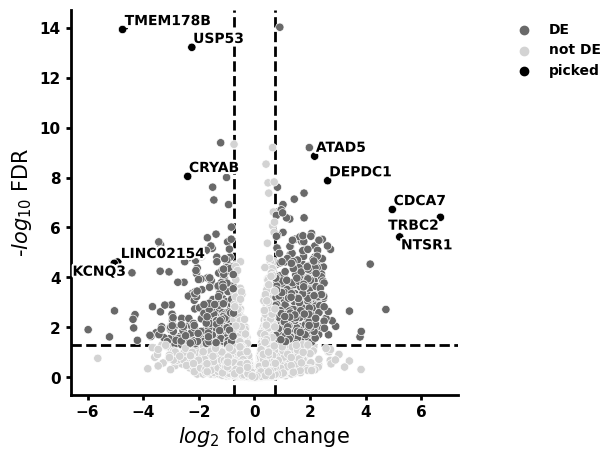

In [33]:

from sanbomics.plots import volcano
volcano(res, symbol='Sym')

# Question 3: GSEA

## 3.2 Prerank

In [34]:
'''
TODO: Drop na from differential gene expression results.
      Prerank the significant de genes based on a statistics of your choice.

Hint: You could use the GSEAPY package: https://gseapy.readthedocs.io/en/latest/introduction.html
'''
ranks = significant_genes[['Symbols','stat']].dropna().sort_values('stat', ascending = False)
ranks

,Symbols,stat
Gene_ID,,
ENSG00000203760,CENPW,7.299164
ENSG00000176208,ATAD5,7.155697
ENSG00000024526,DEPDC1,6.780578
ENSG00000112312,GMNN,6.557348
ENSG00000132780,NASP,6.461117
...,...,...
ENSG00000197746,PSAP,-6.836363
ENSG00000109846,CRYAB,-6.863888
ENSG00000106366,SERPINE1,-7.416125


## 3.3 Libraries

In [35]:
'''
TODO: Explore the available gene sets libraries.

Hints: gp.get_library_name()

'''
gp.get_library_name(organism='human')

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2

## 3.5 GSEA

In [36]:
'''
TODO:  Perform gsea using the 'GO_Biological_Process_2023' library.
'''

pre_res = gp.prerank(rnk=ranks, gene_sets='GO_Biological_Process_2023')
pre_res.res2d.head(5)


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,DNA Metabolic Process (GO:0006259),0.572934,3.625449,0.0,0.0,0.0,37/51,26.13%,ORC6;HMGB3;RFC4;EXO1;WDHD1;BLM;XRCC2;KPNA2;FAN...
1,prerank,Positive Regulation Of Cell Cycle Process (GO:...,0.607676,3.421446,0.0,0.0,0.0,32/34,38.53%,MAD2L1;AURKB;CDCA8;SMC4;PLK4;CDC6;NCAPG2;SPAG5...
2,prerank,DNA Repair (GO:0006281),0.508108,3.117362,0.0,0.0,0.0,42/42,52.76%,RFC4;EXO1;WDHD1;BLM;XRCC2;FANCA;TIMELESS;POLD1...
3,prerank,DNA-templated DNA Replication (GO:0006261),0.585602,2.986227,0.0,0.0,0.0,23/29,28.48%,ORC6;GINS2;RFC4;WDHD1;HMGA1;BLM;CDC45;POLD1;PO...
4,prerank,DNA Damage Response (GO:0006974),0.51453,2.975505,0.0,0.0,0.0,30/39,34.67%,RFC4;EXO1;WDHD1;BLM;XRCC2;FANCA;TIMELESS;POLD1...


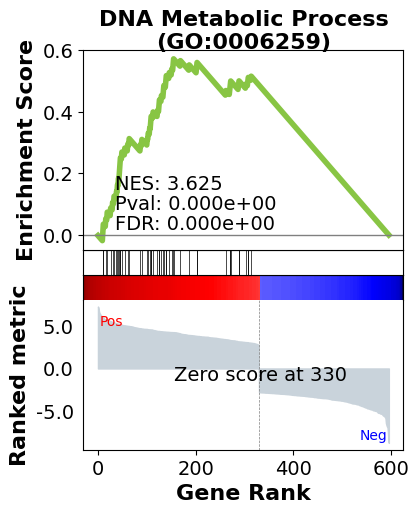

In [37]:
'''
TODO:  Identify another top GO term and generate its gsea plot.
'''
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[0])

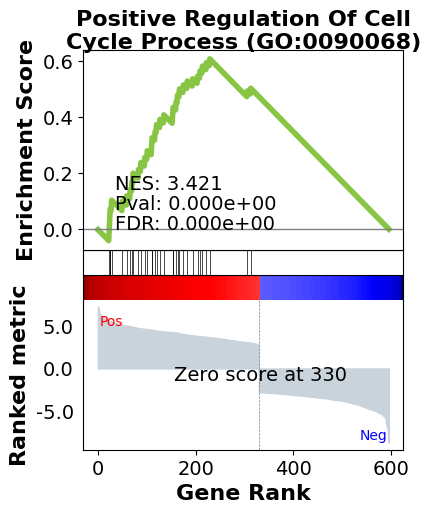

In [38]:
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[1])

## 3.7 GO term similarity network

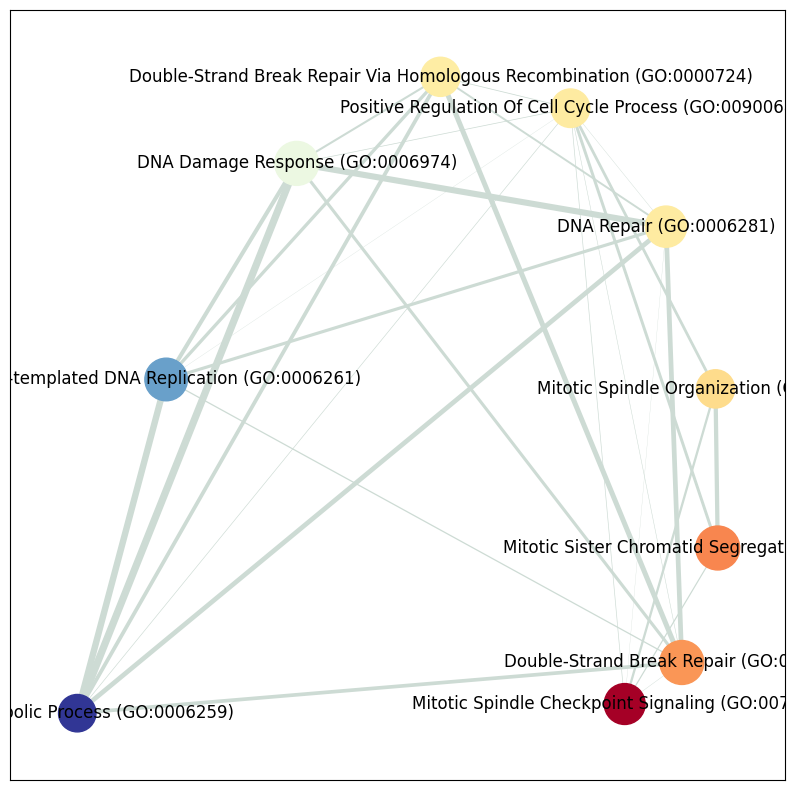

In [39]:
'''
TODO: Generate a plot of GO term similarity network

Hint: You could use networkx and enrichment_map from gseapy
'''

from gseapy import enrichment_map

nodes, edges = enrichment_map(pre_res.res2d)

import networkx as nx

G = nx.from_pandas_edgelist(edges,
                            source='src_idx',
                            target='targ_idx',
                            edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])

fig, ax = plt.subplots(figsize=(10, 10))


pos=nx.layout.spiral_layout(G)

nx.draw_networkx_nodes(G,
                       pos=pos,
                       cmap=plt.cm.RdYlBu,
                       node_color=list(nodes.NES),
                       node_size=list(nodes.Hits_ratio *1000))
# draw node label
nx.draw_networkx_labels(G,
                        pos=pos,
                        labels=nodes.Term.to_dict())
# draw edge
edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
nx.draw_networkx_edges(G,
                       pos=pos,
                       width=list(map(lambda x: x*10, edge_weight)),
                       edge_color='#CDDBD4')
plt.show()